In [2]:
#All imports and data files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from datetime import timedelta
from time import time
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import statsmodels.api as sm

dataset = pd.read_csv('Out_60.csv')
dataset = dataset.drop(["Unnamed: 0", 'last_outcome_category', 'location'], axis=1)
mask = dataset['ward_name']!=dataset['ward_name']
dataset = dataset[~mask]

# Sarima

In [8]:
# Sets the timeseries start and end date, creates the timeseries for the entire dataset, 
data_start = date(2010, 12, 1)
data_end = date(2022, 9, 1)

groups = dataset.groupby('month')
sarima_timeseries = groups.count()['longitude']
sarima_timeseries = pd.Series(sarima_timeseries.values,index=[pd.Timestamp(x, freq='M') for x in sarima_timeseries.index])
sarima_timeseries = sarima_timeseries[data_start:data_end]
sarima_df = pd.DataFrame(sarima_timeseries).reset_index()


def anomaly_avg(timestamp):
    # Gets the average of the month from all other years for each month with troublesome abnormal corona values.
    remove_start = date(2019, 11, 1)
    remove_end = date(2020, 7, 1)
    
    temp = sarima_df[sarima_df['index'].dt.month == timestamp.month]
    temp = temp[temp['index'].dt.year != timestamp.year]
    return int(temp[0].mean())

corona_df = pd.DataFrame(sarima_timeseries[remove_start:remove_end]).reset_index()

# Replaces the corona data with the average of other years for that month.
for x in corona_df['index']:
    sarima_timeseries[x] = anomaly_avg(x)
    
# Takes the first difference of the timeseries.
sarima_timeseries_diff = sarima_timeseries.diff()[1:]
sarima_timeseries_diff = pd.Series(sarima_timeseries_diff.values,index=[pd.Timestamp(x) for x in sarima_timeseries_diff.index])

P-value of the time series: 0.661
P-value of the first differenced time series: 0.0


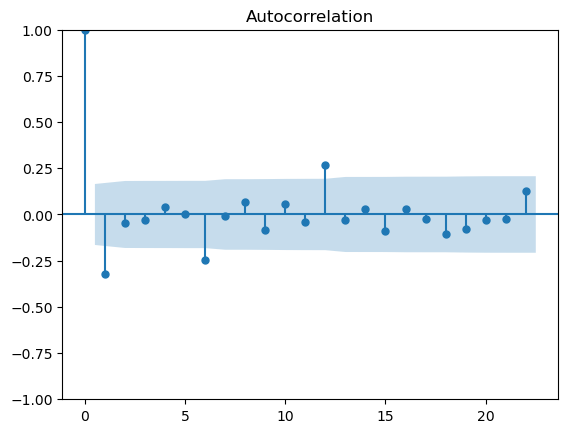

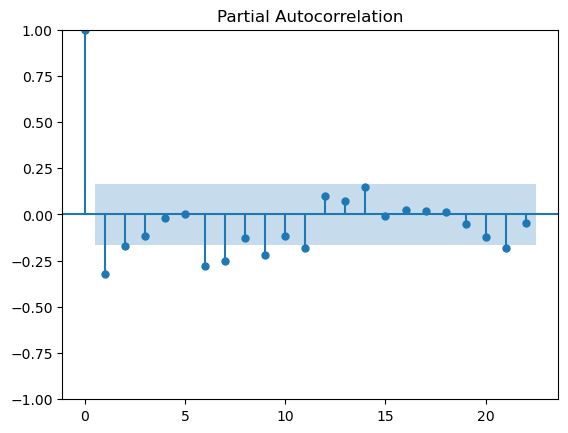

In [9]:
# Prints and plots the ACF and PACF plots and the augmented dickey fuller tests of the timeseries for the whole dataset.

plot_acf(sarima_timeseries_diff);
adfull_time = adfuller(sarima_timeseries)
print('P-value of the time series:', round(adfull_time[1], 3))
adfull_time = adfuller(sarima_timeseries_diff)
print('P-value of the first differenced time series:', round(adfull_time[1], 3))
plot_pacf(sarima_timeseries_diff, method='ywm');

In [14]:
# Set of functions to prepare a given timeseries, create and fit a model for it, plot the results of that model and 
# get the performance metrics of the model. 
# All functions are to run for individual wards.

def prepare_timeseries(timeseries):
    # Takes a time series, allows for the changing of its start and end date,
    # and sets its index to be TimeStamp instead of a string for ease of use.
    # Returns that timeseries
    
    data_start = date(2010, 12, 1)
    data_end = date(2022, 9, 1)
    timeseries = pd.Series(timeseries.values,index=[pd.Timestamp(x, freq='M') for x in timeseries.index])
    timeseries = timeseries[data_start:data_end]
    
    return timeseries

def training(timeseries):
    # Takes a timeseries, allows for choosing of end date of training and testing data.
    # Splits the timeseries into a training and testing set, and returns these sets.
    train_end = date(2022, 1, 1)
    test_end = date(2022, 9, 1)

    train_data = timeseries[:train_end]
    test_data = timeseries[train_end+timedelta(days=1):test_end]
    
    return train_data, test_data

def corona_troubles(timeseries):
    # Takes a timeseries, takes a specified start and end date (in this case the abnormal corona months), 
    # finds the average for these months of all other years and replaces the abnormal data.
    # return the updated timeseries
    remove_start = date(2019, 11, 1)
    remove_end = date(2020, 7, 1)
    temp_df = pd.DataFrame(timeseries).reset_index()
    
    
    for x in timeseries[remove_start:remove_end].index:
        temp = temp_df[temp_df['index'].dt.month == x.month]
        temp = temp[temp['index'].dt.year != x.year]
        timeseries[x] = int(temp[0].mean())
        
    return timeseries
    
def rolling_pred_res(train_data, test_data, timeseries, my_order, my_seasonal_order):
    # Takes the train and test data, the timeseries and specified order and seasonal order.
    # Fits the model for each month in the test data individually, and uses that prediction to predict the next month
    # Calculalates the residuals by subtracting the predictions from the test data.
    # returns the predictions, the residuals and the fitted model.
    rolling_predictions = test_data.copy()
    for train_end in test_data.index:
        train_data = timeseries[:train_end-timedelta(days=1)]
        model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
        model_fit = model.fit()

        pred = model_fit.forecast()
        rolling_predictions[train_end] = pred

    rolling_residuals = test_data - rolling_predictions
    
    return rolling_predictions, rolling_residuals, model_fit

def plot_rolling_residuals(rolling_residuals):
    # Takes the residuals and plots them.
    plt.figure(figsize=(10,4))
    plt.plot(rolling_residuals)
    plt.axhline(0, linestyle='--', color='k')
    plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
    plt.ylabel('Error', fontsize=16);
    

def plot_rolling_predictions(timeseries, rolling_predictions):
    # gets the timeseries and the predictons and plots the predictions overlayed on top of the timeseries.
    plt.figure(figsize=(10,4))
    
    start_date = timeseries.index[0]
    end_date = timeseries.index[-1]

    plt.plot(timeseries)
    plt.plot(rolling_predictions)

    plt.legend(('Data', 'Predictions'), fontsize=16)

    plt.title('Rolling Forecast prediction Crimes in Barnet', fontsize=20)
    plt.ylabel('Crimes', fontsize=16)
    for year in range(start_date.year+1,end_date.year+1):
        plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
        
        
def rolling_statistics(rolling_residuals, test_data):
    # Calculates the MAPE and RMSE for the residuals against the test data. 
    # Returns the MAPE and RMSE
    RMAPE = round(np.mean(abs(rolling_residuals/test_data)),4)
    RRMSE = np.sqrt(np.mean(rolling_residuals**2))
    
    return RMAPE, RRMSE

In [19]:
def run_functions(temp_timeseries):
    # Takes a timeseries and runs them through all of the previous functions to prepare the timeseries
    # create and fit the model, plot the results and return the MAPE and RMSE.
    
    temp_timeseries = prepare_timeseries(temp_timeseries)
    temp_timeseries = corona_troubles(temp_timeseries)
    temp_train, temp_test = training(temp_timeseries)

    temp_rolling_predictions, temp_rolling_residuals, model_fit = rolling_pred_res(temp_train, temp_test, temp_timeseries, my_order, my_seasonal_order)
    plot_rolling_residuals(temp_rolling_residuals)
    plot_rolling_predictions(temp_timeseries, temp_rolling_predictions)
    temp_rmape, temp_rrmse = rolling_statistics(temp_rolling_residuals, temp_test)
    
    return temp_rmape, temp_rrmse, model_fit

def run_functions_no_plot(temp_timeseries):
    # Takes a timeseries and runs them through all of the previous functions to prepare the timeseries
    # create and fit the model, without plotting the results and return the MAPE and RMSE.
    
    temp_timeseries = prepare_timeseries(temp_timeseries)
    temp_timeseries = corona_troubles(temp_timeseries)
    temp_train, temp_test = training(temp_timeseries)

    temp_rolling_predictions, temp_rolling_residuals, model_fit = rolling_pred_res(temp_train, temp_test, temp_timeseries, my_order, my_seasonal_order)
    temp_rmape, temp_rrmse = rolling_statistics(temp_rolling_residuals, temp_test)
    
    return temp_rmape, temp_rrmse, model_fit

In [272]:
# Creates a list of tuples containing every likely combination of parameters for the order parameters
orders = []
for x in [0,1]:
    for y in [0,1]:
        for z in [0,1,2]:
            orders.append((x,y,z))
        
# Creates a list of tuples containing every likely combination of parameters for the seasonal order parameters
seasonal_orders = []
for x in [1,2]:
    for y in [0]:
        for z in [0,1]:
            for s in [6, 12]:
                seasonal_orders.append((x,y,z,s))

In [235]:
# Initializes the best_order_lst, which at the end will contain the best parameters for each wards,
# with their corresponding performance metrics
best_order_lst = []
i=0
# For each unique ward
for x in tqdm(dataset['ward_name'].unique()):
    i+=1
    start= time()
    looking_lst = []
    # Run through every possible combination of likely order and seasonal order parameters.
    for y in orders:
        for z in seasonal_orders:
            try:
                # Set the order, seasonal order and timeseries to be for the current order, seasonal order and ward.
                my_order = y
                my_seasonal_order = z
                df_temp = dataset[dataset['ward_name'] == x]
                temp_timeseries = df_temp.groupby("month").count()['latitude']
                
                # Run the run_functions() function for this timeseries with these parameters
                new_temp_mape, new_temp_rmse = run_functions(temp_timeseries)
                # Add the MAPE and RMSE to a list for later comparison
                looking_lst.append([(x,y,z), new_temp_mape, new_temp_rmse])
            except:
                # Try, except to account for certain combinations of parameters for certain wards.
                print((x,y,z), 'Does not work')
    
    lowest = 1
    # Finds the lowest MAPE in the looking list, and adds that set of parameters to the best_order_lst
    for val in looking_lst:
        if val[1] < lowest:
            lowest = val[1]
            best = val
    best_order_lst.append(best)
    end = time()
    print('{} took {} seconds.'.format(x, end-start))
    print('Best:', best)
    

  4%|███▎                                                                            | 1/24 [02:41<1:02:00, 161.75s/it]

High Barnet took 161.75029730796814 seconds.
Best: [('High Barnet', (0, 0, 0), (1, 0, 0, 12)), 0.1859, 1.541103500742244]


  8%|██████▊                                                                           | 2/24 [04:54<53:08, 144.95s/it]

Underhill took 133.19078636169434 seconds.
Best: [('Underhill', (1, 0, 1), (2, 0, 1, 6)), 0.425, 1.8027756377319946]


 12%|██████████▎                                                                       | 3/24 [07:52<55:55, 159.79s/it]

East Barnet took 177.45378947257996 seconds.
Best: [('East Barnet', (0, 0, 1), (1, 0, 0, 12)), 0.3512, 1.7320508075688772]


 17%|█████████████▋                                                                    | 4/24 [10:13<50:52, 152.61s/it]

Barnet Vale took 141.5876989364624 seconds.
Best: [('Barnet Vale', (0, 0, 1), (2, 0, 0, 6)), 0.2572, 2.3717082451262845]


 21%|█████████████████                                                                 | 5/24 [12:45<48:12, 152.23s/it]

Edgwarebury took 151.5725016593933 seconds.
Best: [('Edgwarebury', (0, 1, 2), (1, 0, 0, 6)), 0.2646, 1.1726039399558574]


 25%|████████████████████▌                                                             | 6/24 [15:51<49:05, 163.63s/it]

Totteridge & Woodside took 185.75988364219666 seconds.
Best: [('Totteridge & Woodside', (0, 0, 0), (2, 0, 0, 12)), 0.2679, 3.0618621784789726]
('Whetstone', (1, 1, 2), (2, 0, 1, 6)) Does not work


 29%|███████████████████████▉                                                          | 7/24 [19:27<51:11, 180.66s/it]

Whetstone took 215.72865056991577 seconds.
Best: [('Whetstone', (0, 1, 1), (1, 0, 0, 6)), 0.1949, 2.091650066335189]


 33%|███████████████████████████▎                                                      | 8/24 [22:12<46:53, 175.83s/it]

Brunswick Park took 165.47792410850525 seconds.
Best: [('Brunswick Park', (1, 1, 0), (1, 0, 1, 12)), 0.3772, 2.622022120425379]


 38%|██████████████████████████████▊                                                   | 9/24 [25:13<44:21, 177.42s/it]

Woodhouse took 180.91035914421082 seconds.
Best: [('Woodhouse', (0, 0, 0), (2, 0, 0, 6)), 0.3013, 2.1213203435596424]


 42%|█████████████████████████████████▊                                               | 10/24 [27:51<39:58, 171.34s/it]

Edgware took 157.72220873832703 seconds.
Best: [('Edgware', (0, 0, 1), (2, 0, 1, 12)), 0.1818, 2.3979157616563596]


 46%|█████████████████████████████████████▏                                           | 11/24 [31:22<39:47, 183.63s/it]

Friern Barnet took 211.50728583335876 seconds.
Best: [('Friern Barnet', (0, 0, 0), (2, 0, 1, 6)), 0.0734, 1.5]
('Mill Hill', (0, 1, 2), (1, 0, 1, 12)) Does not work


 50%|████████████████████████████████████████▌                                        | 12/24 [35:16<39:45, 198.79s/it]

Mill Hill took 233.44328999519348 seconds.
Best: [('Mill Hill', (0, 0, 1), (1, 0, 0, 12)), 0.2139, 2.7613402542968153]
('Burnt Oak', (1, 0, 0), (1, 0, 1, 6)) Does not work


 54%|███████████████████████████████████████████▉                                     | 13/24 [38:32<36:19, 198.18s/it]

Burnt Oak took 196.77164793014526 seconds.
Best: [('Burnt Oak', (1, 0, 1), (1, 0, 0, 6)), 0.4433, 5.522680508593631]
('West Finchley', (1, 0, 0), (1, 0, 1, 6)) Does not work
('West Finchley', (1, 0, 0), (2, 0, 1, 6)) Does not work


 58%|███████████████████████████████████████████████▎                                 | 14/24 [41:51<33:03, 198.33s/it]

West Finchley took 198.66871619224548 seconds.
Best: [('West Finchley', (0, 1, 1), (1, 0, 1, 12)), 0.2999, 2.7613402542968153]
('Finchley Church End', (1, 0, 0), (1, 0, 1, 12)) Does not work


 62%|██████████████████████████████████████████████████▋                              | 15/24 [45:01<29:22, 195.84s/it]

Finchley Church End took 190.07277631759644 seconds.
Best: [('Finchley Church End', (0, 0, 2), (1, 0, 0, 6)), 0.1267, 1.5811388300841898]
('Colindale North', (1, 0, 2), (2, 0, 1, 12)) Does not work


 67%|██████████████████████████████████████████████████████                           | 16/24 [48:49<27:23, 205.47s/it]

Colindale North took 227.82957005500793 seconds.
Best: [('Colindale North', (0, 0, 0), (2, 0, 0, 6)), 0.2292, 1.5811388300841898]
('East Finchley', (1, 0, 0), (2, 0, 1, 6)) Does not work


 71%|█████████████████████████████████████████████████████████▍                       | 17/24 [51:44<22:54, 196.31s/it]

East Finchley took 175.00836634635925 seconds.
Best: [('East Finchley', (0, 0, 0), (2, 0, 1, 12)), 0.3156, 3.0618621784789726]


 75%|████████████████████████████████████████████████████████████▊                    | 18/24 [54:47<19:13, 192.33s/it]

Hendon took 183.0688135623932 seconds.
Best: [('Hendon', (1, 0, 0), (1, 0, 0, 6)), 0.5806, 9.334077351297235]


 79%|████████████████████████████████████████████████████████████████▏                | 19/24 [57:37<15:27, 185.55s/it]

Garden Suburb took 169.75254845619202 seconds.
Best: [('Garden Suburb', (1, 1, 0), (1, 0, 1, 6)), 0.2307, 1.8371173070873836]


 83%|█████████████████████████████████████████████████████████████████▊             | 20/24 [1:00:11<11:45, 176.26s/it]

West Hendon took 154.6012670993805 seconds.
Best: [('West Hendon', (1, 1, 1), (1, 0, 0, 6)), 0.1589, 2.091650066335189]


 88%|█████████████████████████████████████████████████████████████████████▏         | 21/24 [1:03:11<08:52, 177.34s/it]

Golders Green took 179.87894487380981 seconds.
Best: [('Golders Green', (0, 0, 0), (1, 0, 0, 6)), 0.29, 3.7416573867739413]


 92%|████████████████████████████████████████████████████████████████████████▍      | 22/24 [1:06:29<06:06, 183.43s/it]

Childs Hill took 197.63284730911255 seconds.
Best: [('Childs Hill', (0, 1, 2), (2, 0, 0, 6)), 0.2775, 5.431390245600108]


 96%|███████████████████████████████████████████████████████████████████████████▋   | 23/24 [1:08:58<02:53, 173.27s/it]

Cricklewood took 149.55541062355042 seconds.
Best: [('Cricklewood', (0, 0, 1), (1, 0, 0, 6)), 0.2417, 3.7080992435478315]
('Colindale South', (1, 0, 1), (1, 0, 1, 12)) Does not work
('Colindale South', (1, 0, 1), (2, 0, 1, 12)) Does not work
('Colindale South', (1, 0, 2), (2, 0, 1, 6)) Does not work
('Colindale South', (1, 1, 2), (2, 0, 1, 6)) Does not work


100%|███████████████████████████████████████████████████████████████████████████████| 24/24 [1:10:40<00:00, 176.70s/it]

Colindale South took 101.88161993026733 seconds.
Best: [('Colindale South', (0, 1, 1), (1, 0, 0, 6)), 0.0, 0.0]


In [12]:
# Copy of the best_order_lst after running the cell above. 
# Cell above takes an hour to run, so this can sometimes be easier.
best_order_lst = [[('High Barnet', (0, 0, 0), (1, 0, 0, 12)), 0.1859, 1.541103500742244], [('Underhill', (1, 0, 1), (2, 0, 1, 6)), 0.425, 1.8027756377319946], [('East Barnet', (0, 0, 1), (1, 0, 0, 12)), 0.3512, 1.7320508075688772], [('Barnet Vale', (0, 0, 1), (2, 0, 0, 6)), 0.2572, 2.3717082451262845], [('Edgwarebury', (0, 1, 2), (1, 0, 0, 6)), 0.2646, 1.1726039399558574], [('Totteridge & Woodside', (0, 0, 0), (2, 0, 0, 12)),  0.2679,  3.0618621784789726], [('Whetstone', (0, 1, 1), (1, 0, 0, 6)), 0.1949, 2.091650066335189],[('Brunswick Park', (1, 1, 0), (1, 0, 1, 12)), 0.3772, 2.622022120425379],[('Woodhouse', (0, 0, 0), (2, 0, 0, 6)), 0.3013, 2.1213203435596424], [('Edgware', (0, 0, 1), (2, 0, 1, 12)), 0.1818, 2.3979157616563596], [('Friern Barnet', (0, 0, 0), (2, 0, 1, 6)), 0.0734, 1.5], [('Mill Hill', (0, 0, 1), (1, 0, 0, 12)), 0.2139, 2.7613402542968153], [('Burnt Oak', (1, 0, 1), (1, 0, 0, 6)), 0.4433, 5.522680508593631], [('West Finchley', (0, 1, 1), (1, 0, 1, 12)), 0.2999, 2.7613402542968153], [('Finchley Church End', (0, 0, 2), (1, 0, 0, 6)),  0.1267,  1.5811388300841898], [('Colindale North', (0, 0, 0), (2, 0, 0, 6)), 0.2292, 1.5811388300841898], [('East Finchley', (0, 0, 0), (2, 0, 1, 12)), 0.3156, 3.0618621784789726], [('Hendon', (1, 0, 0), (1, 0, 0, 6)), 0.5806, 9.334077351297235], [('Garden Suburb', (1, 1, 0), (1, 0, 1, 6)), 0.2307, 1.8371173070873836], [('West Hendon', (1, 1, 1), (1, 0, 0, 6)), 0.1589, 2.091650066335189], [('Golders Green', (0, 0, 0), (1, 0, 0, 6)), 0.29, 3.7416573867739413], [('Childs Hill', (0, 1, 2), (2, 0, 0, 6)), 0.2775, 5.431390245600108], [('Cricklewood', (0, 0, 1), (1, 0, 0, 6)), 0.2417, 3.7080992435478315], [('Colindale South', (0, 1, 1), (1, 0, 0, 6)), 0.0, 0.0]]

In [22]:
def forecast(ward, my_order, my_seasonal_order):
    # Function that takes a ward, order and seasonal order 
    # and returns the predicted value for the first month not in the datsaet
    df_temp = dataset[dataset['ward_name'] == ward]
    temp_timeseries = df_temp.groupby("month").count()['latitude']
    x, y, new_model_fit = run_functions_no_plot(temp_timeseries)
    return [x for x in new_model_fit.forecast(8)][7]

    
forecast('Underhill', (0,0,0), (2,0,0,6))

2.951648387716096

In [24]:
# Runs the forecasting function for each ward and saves it in a dictionary
forecast_dct = {}
for x in best_order_lst:
    ward = x[0][0]
    my_order = x[0][1]
    my_seasonal_order = x[0][2]
    forecast_dct[ward] =  round(forecast(ward, my_order, my_seasonal_order))
    

In [25]:
forecast_dct

{'High Barnet': 6,
 'Underhill': 3,
 'East Barnet': 2,
 'Barnet Vale': 5,
 'Edgwarebury': 5,
 'Totteridge & Woodside': 5,
 'Whetstone': 6,
 'Brunswick Park': 6,
 'Woodhouse': 5,
 'Edgware': 8,
 'Friern Barnet': 7,
 'Mill Hill': 8,
 'Burnt Oak': 10,
 'West Finchley': 11,
 'Finchley Church End': 6,
 'Colindale North': 3,
 'East Finchley': 9,
 'Hendon': 2,
 'Garden Suburb': 5,
 'West Hendon': 9,
 'Golders Green': 6,
 'Childs Hill': 17,
 'Cricklewood': 3,
 'Colindale South': 2}